<h2 align="center">ML Housing Predict System </h2>

### Load Necessary Libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor

### Loading Data 

In [2]:
df = pd.read_csv("bengaluru_house_prices.csv")
df.shape 

(13320, 9)

In [3]:
df.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [5]:
unique_size = df["size"].unique()
unique_size 

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [6]:
# Count the different area type 

In [7]:
df.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [8]:
df.sample(1)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
644,Super built-up Area,Ready To Move,6th Phase JP Nagar,2 BHK,NaN,1180,2.0,3.0,80.0


### Feature selection 

In [9]:
# drop unecessary features 
df_2 = df.drop(["availability","society","balcony","area_type"] , axis="columns")
df_2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<h2 align="center"> Data Cleaning & EDA </h2>

### Find and treat NA values 

In [10]:
df_2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [11]:
# drop all the null values 
df_3 = df_2.dropna()
df_3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

### creating new BHK columns 

In [12]:
df_3["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [13]:
df_3["bhk"] = df_3["size"].apply(lambda x : int(x.split(" ")[0]))
df_3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df_3["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [15]:
df_3[df_3.bhk > 20 ]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [16]:
df_3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2067,), dtype=object)

Here you there is some kind range in total sqrt but we don't want the number in range so we take average of these two numbers 

### Function for showing range value 

In [17]:
def is_float(x) : 
    try :
        float(x)
    except : 
        return False 
    return True 

In [18]:
df_3[~df_3["total_sqft"].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Here you see we have to types of value in total_sqft , so whenever range vlue will come i will take average of both two number and i will ignore (34.46Sq. Meter) this type of value 

### Python code for tacle range number in total_sqft columns 

In [19]:
def convert_into_avg(x) : 
    tokens = x.split("-")
    if len(tokens)== 2 :
        return (float (tokens[0]) + float (tokens[1]))/2
    try : 
        return float(x) 
    except :
        return None
    
        

In [20]:
convert_into_avg("2234")

2234.0

In [21]:
convert_into_avg("1195 - 1440")

1317.5

In [22]:
convert_into_avg("4125Perch")

In [23]:
df_4 = df_3.copy()

In [24]:
df_4["total_sqft"] = df_4["total_sqft"].apply(convert_into_avg)

In [25]:
df_4.sample(5)

,location,size,total_sqft,bath,price,bhk
6337,Kundalahalli,4 Bedroom,7000.0,4.0,550.00,4
6618,Sarjapur Road,3 BHK,1539.0,3.0,85.00,3
619,Whitefield,3 BHK,1790.0,3.0,100.00,3
8058,Chinnapanahalli,2 BHK,1010.0,2.0,55.00,2
6396,Electronic City Phase II,2 BHK,1065.0,2.0,30.88,2


###  creating Price squre ft col

In [26]:
df_5 = df_4.copy()

In [27]:
df_5["price_sq_ft"] = df_5["price"]*100000 / df_5["total_sqft"]

In [28]:
df_5.head(5)

,location,size,total_sqft,bath,price,bhk,price_sq_ft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


### Explore Location Columns

In [29]:
df_5.location.unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], shape=(1304,), dtype=object)

In [30]:
len(df_5.location.unique())

1304

In [31]:
df_5.location = df_5["location"].apply(lambda x : x.strip())
location_stats = df_5.groupby("location")["location"].agg("count")
location_stats

location
1 Annasandrapalya                                  1
1 Giri Nagar                                       1
1 Immadihalli                                      1
1 Ramamurthy Nagar                                 1
12th cross srinivas nagar banshankari 3rd stage    1
                                                  ..
t.c palya                                          1
tc.palya                                           4
vinayakanagar                                      1
white field,kadugodi                               1
whitefiled                                         1
Name: location, Length: 1293, dtype: int64

In [32]:
# sort the value with descending order 
location_stats = df_5.groupby("location")["location"].agg("count").sort_values(ascending=False)
location_stats


location
Whitefield                            535
Sarjapur  Road                        392
Electronic City                       304
Kanakpura Road                        266
Thanisandra                           236
                                     ... 
poornaprajna layout                     1
pavitra paradise                        1
near Ramanashree California resort      1
mvj engineering college                 1
1Kasavanhalli                           1
Name: location, Length: 1293, dtype: int64

In [33]:
location_stats[location_stats <= 10 ]

location
Kalkere                               10
Sadashiva Nagar                       10
BTM 1st Stage                         10
Basapura                              10
Gunjur Palya                          10
                                      ..
poornaprajna layout                    1
pavitra paradise                       1
near Ramanashree California resort     1
mvj engineering college                1
1Kasavanhalli                          1
Name: location, Length: 1052, dtype: int64

In [34]:
len(location_stats[location_stats <= 10 ])

1052

In [35]:
location_stats_threshold = location_stats[location_stats <= 10 ]

In [36]:
df_5.location = df["location"].apply(lambda x : "other" if x in location_stats_threshold else x )

In [37]:
len(df_5.location.unique())

283

In [38]:
df_5.head(10)

,location,size,total_sqft,bath,price,bhk,price_sq_ft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


### Detect Outliers 

In [47]:
df_5[df_5.total_sqft / df_5.bhk < 300].head(5)

,location,size,total_sqft,bath,price,bhk,price_sq_ft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [42]:
df_5.shape

(13246, 7)

In [51]:
df_6 = df_5[~(df_5.total_sqft / df_5.bhk < 300)]

In [52]:
df_6.shape

(12502, 7)

In [53]:
df_6.head()

,location,size,total_sqft,bath,price,bhk,price_sq_ft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


### Price columns 

In [54]:
df_6.price.describe()

count    12502.000000
mean       111.311915
std        152.089966
min          9.000000
25%         49.000000
50%         70.000000
75%        115.000000
max       3600.000000
Name: price, dtype: float64

In [55]:
df_6.price_sq_ft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_sq_ft, dtype: float64

As tou see the max value is too high and that is outlier and we are going to remove this outlier using IQR method 

### removing outlier from price 

In [63]:
def remove_outlier(df_6) :
    Q1 = df_6.groupby("location")["price_sq_ft"].transform(lambda x : x.quantile(0.25))
    Q3 = df_6.groupby("location")["price_sq_ft"].transform(lambda x : x.quantile(0.75))
    IQR = Q3 - Q1 
    
    return df_6[
        (df_6['price_sq_ft'] >= Q1 - 1.5 * IQR) &
        (df_6['price_sq_ft'] <= Q3 + 1.5 * IQR)
    ] 

df_7 = remove_outlier(df_6)
df_7.shape

    

(11594, 7)

In [64]:
df_7.price_sq_ft.describe()

count    11594.000000
mean      5743.590176
std       2524.773533
min        267.829813
25%       4166.666667
50%       5172.413793
75%       6582.568923
max      27083.333333
Name: price_sq_ft, dtype: float64

In [65]:
df_7.sample()

,location,size,total_sqft,bath,price,bhk,price_sq_ft
7365,other,2 BHK,900.0,2.0,35.0,2,3888.888889


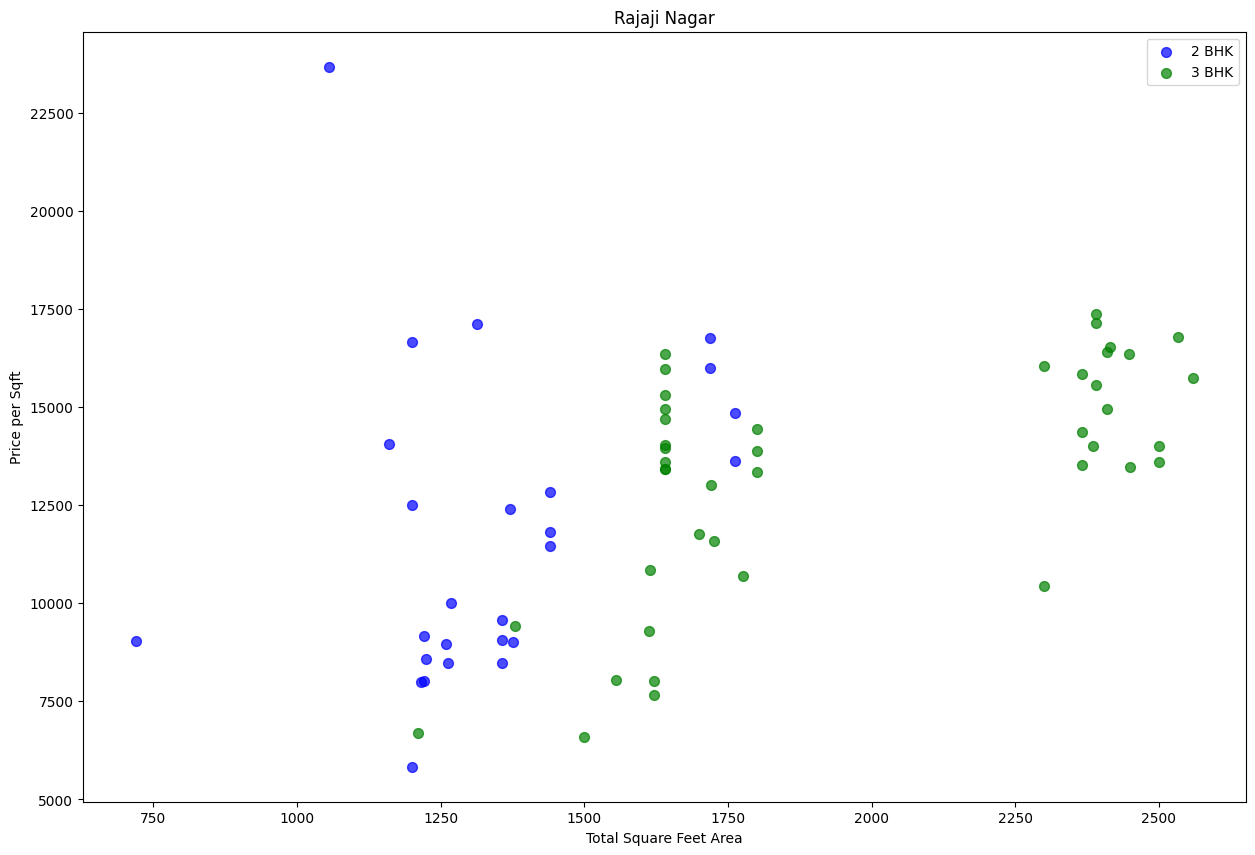

In [75]:
def plot_scatter_chart(df, location):
    data = df[df['location'] == location]

    plt.figure(figsize=(15, 10))

    plt.scatter(
        data[data['bhk'] == 2]['total_sqft'],
        data[data['bhk'] == 2]['price_sq_ft'],
        color='blue',
        label='2 BHK',
        s=50,
        alpha=0.7
    )

    plt.scatter(
        data[data['bhk'] == 3]['total_sqft'],
        data[data['bhk'] == 3]['price_sq_ft'],
        color='green',
        label='3 BHK',
        s=50,
        alpha=0.7
    )

    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per Sqft")
    plt.title(location)
    plt.legend()
    plt.show()


plot_scatter_chart(df_7, "Rajaji Nagar")

we eliminate illogical listings by removing 2 BHK apartments whose price per square foot is lower than the average price per square foot of 1 BHK apartments within the same location.

In [76]:
import numpy as np

def remove_bhk_outliers(df):
    output_df = pd.DataFrame()

    for location, location_df in df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': bhk_df.price_sq_ft.mean(),
                'count': bhk_df.shape[0]
            }

        cleaned_rows = []
        for bhk, bhk_df in location_df.groupby('bhk'):
            if bhk - 1 in bhk_stats and bhk_stats[bhk - 1]['count'] > 5:
                cleaned_rows.append(
                    bhk_df[bhk_df.price_sq_ft < bhk_stats[bhk - 1]['mean']]
                )
            else:
                cleaned_rows.append(bhk_df)

        output_df = pd.concat([output_df] + cleaned_rows, ignore_index=True)

    return output_df


In [77]:
df_8 = remove_bhk_outliers(df_7)
df_8.shape

(7864, 7)

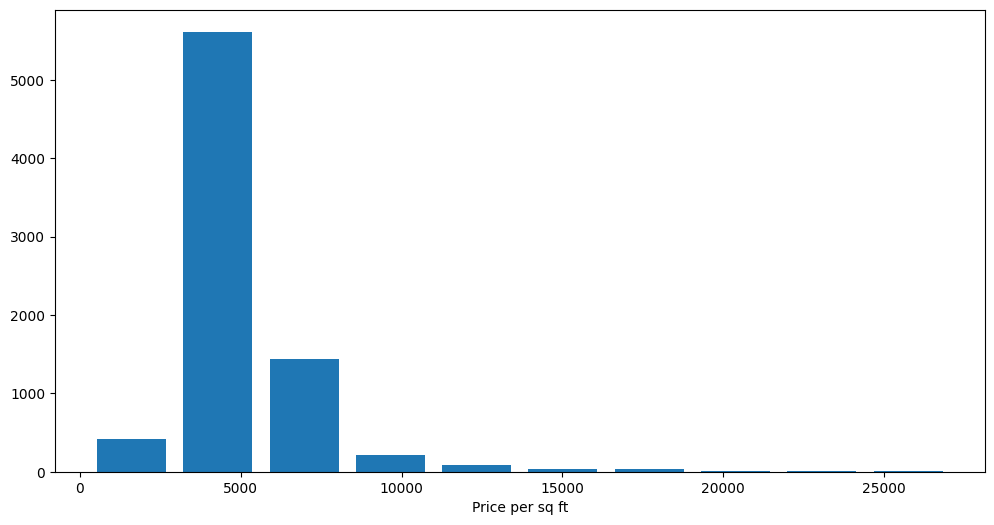

In [84]:
plt.figure(figsize=(12 ,6))
plt.hist(df_8.price_sq_ft , rwidth=0.8)
plt.xlabel("Price per sq ft")
plt.show()

### Detect Bathroom outlier

In [85]:
df_8.bath.unique()

array([ 1.,  2.,  3.,  4.,  5.,  8.,  7.,  6.,  9., 12., 10., 13., 16.])

In [86]:
df_8[df_8.bath > 10 ]

,location,size,total_sqft,bath,price,bhk,price_sq_ft
4560,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
7858,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
7861,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
7862,other,13 BHK,5425.0,13.0,275.0,13,5069.124424
7863,other,16 BHK,10000.0,16.0,550.0,16,5500.000000


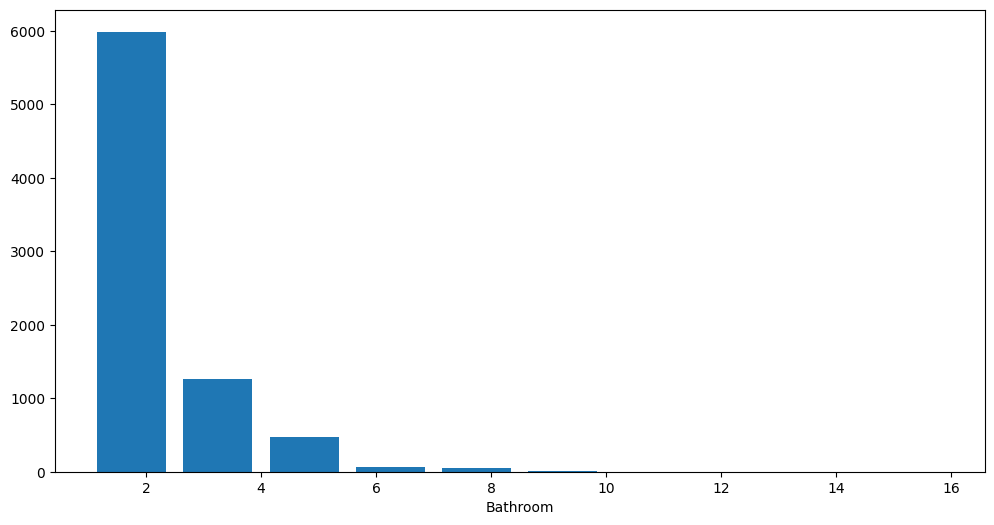

In [88]:
plt.figure(figsize=(12 ,6))
plt.hist(df_8.bath , rwidth=0.8)
plt.xlabel("Bathroom")
plt.show()

In [91]:
df_8[df_8.bath > df_8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_sq_ft
1410,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
4509,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429


In [93]:
df_9 = df_8[df_8.bath < df_8.bhk+2]
df_9.shape

(7831, 7)